## MACS 30150, PS 5 <br/> Keertana V. Chidambaram

### Problem 1

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import lognorm
from scipy.stats import describe
import scipy.optimize as opt
import scipy.integrate as intgr
import pandas as pd
import numpy.linalg as lin

In [2]:
#load and check data
file = "data/incomes.txt"
incomes = np.loadtxt(file)
print(describe(incomes))
print(incomes[:5])

DescribeResult(nobs=200, minmax=(47628.5606361183, 139079.3515487229), mean=85276.82360625811, variance=325358364.04977775, skewness=0.4435576949382467, kurtosis=-0.052433386545345684)
[53711.54439888 99731.23334901 84773.60541676 75184.025931
 73390.9559334 ]


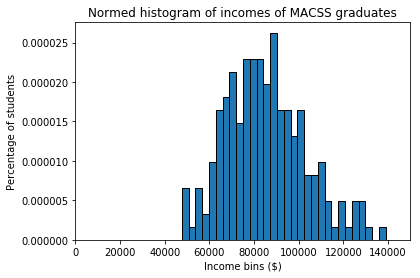

In [3]:
#Solution 1.a.
def plot_histogram(incomes, lb, ub):
    plt.hist(incomes, bins=30, density=True, edgecolor = "k")
    plt.xlabel("Income bins ($)")
    plt.ylabel("Percentage of students")
    plt.title("Normed histogram of incomes of MACSS graduates")
    plt.xlim([lb, ub])
lb, ub = 0, 150000
plot_histogram(incomes, lb, ub)
plt.show()

In [4]:
#Solution 1.b.
def data_moments(xvals):
    mean_data = xvals.mean()
    std_data = xvals.std()    
    return mean_data, std_data

In [5]:
def model_moments(mu, sigma, lb, ub):
    xfx = lambda x: x * lognorm.pdf(x, s=sigma, scale=np.exp(mu))
    (mean_model, m_m_err) = intgr.quad(xfx, lb, ub)
    x2fx = lambda x: ((x - mean_model) ** 2) * lognorm.pdf(x, s=sigma, scale=np.exp(mu))
    (var_model, v_m_err) = intgr.quad(x2fx, lb, ub)
    return mean_model, var_model ** 0.5

In [6]:
def err_vec(xvals, mu, sigma, lb, ub, simple=False):
    mean_data, std_data = data_moments(xvals)
    moms_data = np.array([[mean_data], [std_data]])
    mean_model, std_model = model_moments(mu, sigma, lb, ub)
    moms_model = np.array([[mean_model], [std_model]])
    if simple:
        err_vec = moms_model - moms_data
    else:
        err_vec = (moms_model - moms_data) / moms_data
    return err_vec

In [7]:
def criterion(params, *args):
    mu, sigma = params
    xvals, W, lb, ub = args
    err = err_vec(xvals, mu, sigma, lb, ub, simple=False)
    crit_val = err.T @ W @ err
    return crit_val

In [8]:
mu_init, sig_init = 11, 0.5
w_hat = np.eye(2)
lb, ub = 0, 150000
params_init = np.array([mu_init, sig_init])
gmm_args = (incomes, w_hat, lb, ub)

results = opt.minimize(criterion, params_init, args=(gmm_args),
                       tol=1e-14, method='L-BFGS-B', bounds=((1e-10, None), (1e-10, None)))
#because we are dealing with incomes, we bound the mean to be positive as well.

print("GMM output:")
print(results)

GMM output:
      fun: array([[5.08124726e-16]])
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([2.27335761e-10, 4.17919932e-11])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 54
      nit: 11
   status: 0
  success: True
        x: array([11.33691036,  0.21302707])


GMM estimates:
mu = 11.336910355090003, sigma = 0.21302707020261832
Comparison of GMM estimates with histogram:


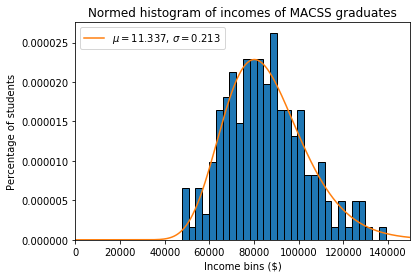

Minimized value of criterion function = [[5.08124726e-16]]
Data moments: Mean = 85276.82360625811, Std deviation = 17992.542128046523
Model moments: Mean = 85276.8243593431, Std deviation = 17992.541754885773


In [9]:
mu_GMM1, sig_GMM1 = results.x
fun_val = results.fun
print("GMM estimates:")
print("mu = {}, sigma = {}". format(mu_GMM1, sig_GMM1))

print("Comparison of GMM estimates with histogram:")
#histrogram plot
plot_histogram(incomes, 0, 150000)
#GMM estimates plot
x_vals = np.linspace(0, 150000, 10000)
ln_pdf = lognorm.pdf(x_vals, s=sig_GMM1, scale=np.exp(mu_GMM1))
plt.plot(x_vals, ln_pdf, label="$\mu = {:.3f}$, $\sigma = {:.3f}$". format(mu_GMM1, sig_GMM1))
plt.legend(loc='upper left')
plt.show()

print("Minimized value of criterion function =", fun_val)

mu_data, sig_data = data_moments(incomes)
mu_model, sig_model = model_moments(mu_GMM1, sig_GMM1, lb, ub)
print("Data moments: Mean = {}, Std deviation = {}".format(mu_data, sig_data))
print("Model moments: Mean = {}, Std deviation = {}".format(mu_model, sig_model))

We can notice that the model and data moments are almost the same.

In [10]:
#Solution 1.c.
def get_Err_mat2(xvals, mu, sigma, lb, ub, simple=False):
    R = 2
    N = len(xvals)
    Err_mat = np.zeros((R, N))
    mean_model, var_model = model_moments(mu, sigma, lb, ub)
    mean_data, var_data = data_moments(xvals)
    if simple:
        Err_mat[0, :] = xvals - mean_model
        Err_mat[1, :] = ((mean_data - xvals) ** 2) - var_model
    else:
        Err_mat[0, :] = (xvals - mean_model) / mean_model
        Err_mat[1, :] = (((mean_data - xvals) ** 2) - var_model) / var_model
    
    return Err_mat

In [11]:
Err_mat = get_Err_mat2(incomes, mu_GMM1, sig_GMM1, lb, ub)
omega = (1 / len(incomes)) * (Err_mat @ Err_mat.T)
w_hat2 = lin.inv(omega)

In [12]:
lb, ub = 0, 150000
params_init = np.array([mu_GMM1, sig_GMM1])
gmm_args = (incomes, w_hat2, lb, ub)

results = opt.minimize(criterion, params_init, args=(gmm_args),
                       tol=1e-14, method='L-BFGS-B', bounds=((1e-10, None), (1e-10, None)))
#because we are dealing with incomes, we bound the mean to be positive as well.

print("GMM output:")
print(results)

GMM output:
      fun: array([[3.79714547e-16]])
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([2.79723477e-08, 4.04651094e-09])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 9
      nit: 1
   status: 0
  success: True
        x: array([11.33691034,  0.21302707])


GMM estimates:
mu = 11.336910341187366, sigma = 0.2130270704050046
Comparison of new GMM estimates with old estimates and histogram:


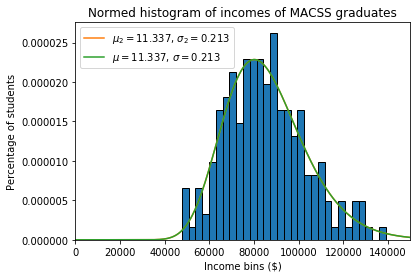

Minimized value of criterion function = [[3.79714547e-16]]
Data moments: Mean = 85276.82360625811, Std deviation = 17992.542128046523
New model moments: Mean = 85276.82326754981, Std deviation = 17992.541591523608


In [13]:
mu_GMM2, sig_GMM2 = results.x
fun_val2 = results.fun
print("GMM estimates:")
print("mu = {}, sigma = {}". format(mu_GMM2, sig_GMM2))

print("Comparison of new GMM estimates with old estimates and histogram:")
#histrogram plot
plot_histogram(incomes, 0, 150000)
#new GMM estimates plot
x_vals = np.linspace(0, 150000, 10000)
ln_pdf2 = lognorm.pdf(x_vals, s=sig_GMM2, scale=np.exp(mu_GMM2))
plt.plot(x_vals, ln_pdf2, label="$\mu_2 = {:.3f}$, $\sigma_2 = {:.3f}$". format(mu_GMM2, sig_GMM2))
#old GMM estimates plot
ln_pdf = lognorm.pdf(x_vals, s=sig_GMM1, scale=np.exp(mu_GMM1))
plt.plot(x_vals, ln_pdf, label="$\mu = {:.3f}$, $\sigma = {:.3f}$". format(mu_GMM1, sig_GMM1))
plt.legend(loc='upper left')
plt.show()

print("Minimized value of criterion function =", fun_val2)

mu_data, sig_data = data_moments(incomes)
mu_model, sig_model = model_moments(mu_GMM2, sig_GMM2, lb, ub)
print("Data moments: Mean = {}, Std deviation = {}".format(mu_data, sig_data))
print("New model moments: Mean = {}, Std deviation = {}".format(mu_model, sig_model))

We notice that with this W matrix too, the model and data moments are very close.

In [14]:
#Solution 1.d.
def data_moments2(xvals, pt1, pt2):
    data_less_pt1 = len(xvals[xvals <= pt1]) / len(xvals)
    data_btw_pt1pt2 = len(xvals[(xvals > pt1) & (xvals <= pt2)]) / len(xvals)
    data_more_pt2 = len(xvals[xvals > pt2]) / len(xvals)
    return (data_less_pt1, data_btw_pt1pt2, data_more_pt2)

In [15]:
def model_moments2(mu, sigma, pt1, pt2, lb, ub):
    pdf = lambda x: lognorm.pdf(x, s=sigma, scale=np.exp(mu))
    (mod_less_pt1, m1_err) = intgr.quad(pdf, lb, pt1)
    (mod_btw_pt1pt2, m1_err) = intgr.quad(pdf, pt1, pt2)
    (mod_more_pt2, m1_err) = intgr.quad(pdf, pt2, ub)
    return (mod_less_pt1, mod_btw_pt1pt2, mod_more_pt2)

In [16]:
def err_vec3(xvals, mu, sigma, pt1, pt2, lb, ub, simple=False):
    data_less_pt1, data_btw_pt1pt2, data_more_pt2 = data_moments2(xvals, pt1, pt2)
    moms_data = np.array([[data_less_pt1], [data_btw_pt1pt2], [data_more_pt2]])
    mod_less_pt1, mod_btw_pt1pt2, mod_more_pt2 = model_moments2(mu, sigma, pt1, pt2, lb, ub)
    moms_model = np.array([[mod_less_pt1], [mod_btw_pt1pt2], [mod_more_pt2]])
    if simple:
        err_vec = moms_model - moms_data
    else:
        err_vec = (moms_model - moms_data) / moms_data
    return err_vec

In [17]:
def criterion2(params, *args):
    mu, sigma = params
    xvals, W, pt1, pt2, lb, ub = args
    err = err_vec3(xvals, mu, sigma, pt1, pt2, lb, ub, simple=False)
    crit_val = err.T @ W @ err
    return crit_val

In [18]:
mu_init, sig_init = 11, 0.5
w_hat = np.eye(3)
lb, ub = 0, 300000
pt1, pt2 = 75000, 100000
params_init = np.array([mu_init, sig_init])
gmm_args = (incomes, w_hat, pt1, pt2, lb, ub)

results = opt.minimize(criterion2, params_init, args=(gmm_args),
                       tol=1e-14, method='L-BFGS-B', bounds=((1e-10, None), (1e-10, None)))
#because we are dealing with incomes, we bound the mean to be positive as well.

print("GMM output:")
print(results)

GMM output:
      fun: array([[7.35878576e-16]])
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([7.01556095e-07, 1.57984428e-07])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 93
      nit: 15
   status: 0
  success: True
        x: array([11.33568133,  0.21059845])


GMM estimates:
mu = 11.335681332391584, sigma = 0.21059845381316233
Comparison of GMM estimates with histogram:


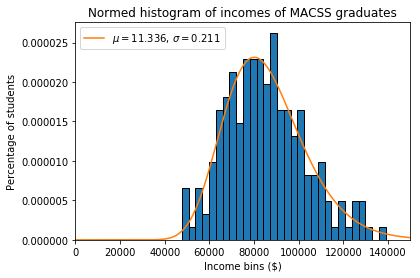

Minimized value of criterion function = [[7.35878576e-16]]
Data moments:
% less than 75k = 0.3, % between 75-100k = 0.5, % more than 100k = 0.2
Model moments:
% less than 75k = 0.2999999955126631, % between 75-100k = 0.5000000072681828, % more than 100k = 0.1999999965310683


In [19]:
mu_GMM3, sig_GMM3 = results.x
fun_val3 = results.fun
print("GMM estimates:")
print("mu = {}, sigma = {}". format(mu_GMM3, sig_GMM3))

print("Comparison of GMM estimates with histogram:")
#histrogram plot
plot_histogram(incomes, 0, 150000)
#GMM estimates plot
x_vals = np.linspace(0, 150000, 10000)
ln_pdf = lognorm.pdf(x_vals, s=sig_GMM3, scale=np.exp(mu_GMM3))
plt.plot(x_vals, ln_pdf, label="$\mu = {:.3f}$, $\sigma = {:.3f}$". format(mu_GMM3, sig_GMM3))
plt.legend(loc='upper left')
plt.show()

print("Minimized value of criterion function =", fun_val3)

data_less_pt1, data_btw_pt1pt2, data_more_pt2 = data_moments2(incomes, pt1, pt2)
mod_less_pt1, mod_btw_pt1pt2, mod_more_pt2 = model_moments2(mu_GMM3, sig_GMM3, pt1, pt2, lb, ub)
print("Data moments:")
print("% less than 75k = {}, % between 75-100k = {}, % more than 100k = {}"\
      .format(data_less_pt1, data_btw_pt1pt2, data_more_pt2))
print("Model moments:")
print("% less than 75k = {}, % between 75-100k = {}, % more than 100k = {}"\
      .format(mod_less_pt1, mod_btw_pt1pt2, mod_more_pt2))

Here also, the model moments closely resemble the data moments

In [20]:
#Solution 1.e.
def get_Err_mat4(xvals, mu, sigma, pt1, pt2, lb, ub, simple=False):
    R = 3
    N = len(xvals)
    Err_mat = np.zeros((R, N))
    mod_less_pt1, mod_btw_pt1pt2, mod_more_pt2 = model_moments2(mu, sigma, pt1, pt2, lb, ub)
    
    pts_in_grp1 = incomes <= pt1
    pts_in_grp2 = (incomes >= 220) & (incomes < 320)
    pts_in_grp3 = (incomes >= 320) & (incomes < 430)
    
    if simple:
        Err_mat[0, :] = pts_in_grp1 - mod_less_pt1
        Err_mat[1, :] = pts_in_grp2 - mod_btw_pt1pt2    
        Err_mat[2, :] = pts_in_grp3 - mod_more_pt2
    else:
        Err_mat[0, :] = (pts_in_grp1 - mod_less_pt1) / mod_less_pt1
        Err_mat[1, :] = (pts_in_grp2 - mod_btw_pt1pt2) / mod_btw_pt1pt2
        Err_mat[2, :] = (pts_in_grp3 - mod_more_pt2) / mod_more_pt2
    
    return Err_mat

In [21]:
Err_mat4 = get_Err_mat4(incomes, mu_GMM2, sig_GMM2, pt1, pt2, lb, ub, True)
omega2 = (1 / len(incomes)) * (Err_mat4 @ Err_mat4.T)
w_hat2 = lin.pinv(omega2)

In [22]:
lb, ub = 0, 300000
pt1, pt2 = 75000, 100000
params_init = np.array([mu_GMM2, sig_GMM2])
gmm_args = (incomes, w_hat2, pt1, pt2, lb, ub)

results = opt.minimize(criterion2, params_init, args=(gmm_args),
                       tol=1e-14, method='L-BFGS-B', bounds=((1e-10, None), (1e-10, None)))
#because we are dealing with incomes, we bound the mean to be positive as well.

print("GMM output:")
print(results)

GMM output:
      fun: array([[1.6431623e-11]])
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 1.19964970e-11, -6.91448546e-12])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 57
      nit: 17
   status: 0
  success: True
        x: array([11.3356692 ,  0.21057505])


GMM estimates:
mu = 11.335669199550667, sigma = 0.21057505061331083
Comparison of GMM estimates with histogram:


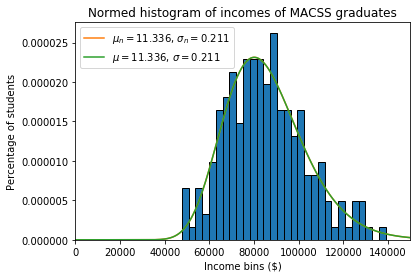

Minimized value of criterion function = [[1.6431623e-11]]
Data moments:
% less than 75k = 0.3, % between 75-100k = 0.5, % more than 100k = 0.2
Model moments:
% less than 75k = 0.2999997646653617, % between 75-100k = 0.5000425530665106, % more than 100k = 0.199957681583161


In [23]:
mu_GMM4, sig_GMM4 = results.x
fun_val4 = results.fun
print("GMM estimates:")
print("mu = {}, sigma = {}". format(mu_GMM4, sig_GMM4))

print("Comparison of GMM estimates with histogram:")
#histrogram plot
plot_histogram(incomes, 0, 150000)
#New GMM estimates plot
x_vals = np.linspace(0, 150000, 10000)
ln_pdf = lognorm.pdf(x_vals, s=sig_GMM4, scale=np.exp(mu_GMM4))
plt.plot(x_vals, ln_pdf, label="$\mu_n = {:.3f}$, $\sigma_n = {:.3f}$". format(mu_GMM4, sig_GMM4))
#Old GMM estimates plot
ln_pdf = lognorm.pdf(x_vals, s=sig_GMM3, scale=np.exp(mu_GMM3))
plt.plot(x_vals, ln_pdf, label="$\mu = {:.3f}$, $\sigma = {:.3f}$". format(mu_GMM3, sig_GMM3))
plt.legend(loc='upper left')
plt.show()

print("Minimized value of criterion function =", fun_val4)

data_less_pt1, data_btw_pt1pt2, data_more_pt2 = data_moments2(incomes, pt1, pt2)
mod_less_pt1, mod_btw_pt1pt2, mod_more_pt2 = model_moments2(mu_GMM4, sig_GMM4, pt1, pt2, lb, ub)
print("Data moments:")
print("% less than 75k = {}, % between 75-100k = {}, % more than 100k = {}"\
      .format(data_less_pt1, data_btw_pt1pt2, data_more_pt2))
print("Model moments:")
print("% less than 75k = {}, % between 75-100k = {}, % more than 100k = {}"\
      .format(mod_less_pt1, mod_btw_pt1pt2, mod_more_pt2))

The following table summarizes the mean, variance and criterion function value for all the four methods:

In [24]:
mu = [mu_GMM1, mu_GMM2, mu_GMM3, mu_GMM4]
sig = [sig_GMM1, sig_GMM2, sig_GMM3, sig_GMM4]
fun = [fun_val, fun_val2, fun_val3, fun_val4]
pd.DataFrame({"mu":mu,"sigma":sig,"GMM Fn Value":fun}, index=['model1', 'model2', 'model3', 'model4']).astype(float)

,mu,sigma,GMM Fn Value
model1,11.336910,0.213027,5.081247e-16
model2,11.336910,0.213027,3.797145e-16
model3,11.335681,0.210598,7.358786e-16
model4,11.335669,0.210575,1.643162e-11


From the table it is clear that there is almost negligible difference between the mu and sigma values calculated by the three methods. Hence, any of the three would be good enough for practical purposes for the given dataset. But upon further investigation, we find that the smallest error value is for model 2 for this data, i.e. the model with mean and standard deviation as moments and with the 2-step weighing matrix. So we can argue that model2 fits the data best.

In [25]:
#Solution 2.a.
df=pd.read_csv("data/sick.txt")
print(df.head())
print(df.describe())

   sick    age  children  avgtemp_winter
0  1.67  57.47      3.04           54.10
1  0.71  26.77      1.20           36.54
2  1.39  41.85      2.31           32.38
3  1.37  51.27      2.46           52.94
4  1.45  44.22      2.72           45.90
             sick         age    children  avgtemp_winter
count  200.000000  200.000000  200.000000      200.000000
mean     1.008600   40.683850    1.674950       44.041250
std      0.504222   11.268686    0.969761       11.101977
min      0.040000   12.810000    0.000000       16.500000
25%      0.650000   33.967500    0.970000       36.112500
50%      0.960000   41.015000    1.560000       43.300000
75%      1.322500   47.750000    2.322500       52.172500
max      2.800000   74.890000    4.960000       68.600000


In [26]:
def err_vec(df ,b_0, b_1, b_2, b_3):
    y_model = b_0 + b_1 * df['age'] + b_2 * df['children'] + b_3 * df['avgtemp_winter']
    y_data = df['sick']
    err_vec = y_model - y_data
    return err_vec

In [27]:
def criterion(params, *args):
    b_0, b_1, b_2, b_3 = params
    df, W = args
    err = err_vec(df, b_0, b_1, b_2, b_3)
    crit_val = err.T @ W @ err
    return crit_val

In [28]:
b_0, b_1, b_2, b_3 = 1, 0, 0, 0
params_init = np.array([b_0, b_1, b_2, b_3])
w_hat = np.eye(len(df))
gmm_args = (df, w_hat)
results = opt.minimize(criterion, params_init, args=(gmm_args), tol=1e-14,method='L-BFGS-B')
results

      fun: 0.0018212898060782808
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 1.63237479e-07, -1.97918938e-06, -5.83402684e-06, -5.58679839e-05])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 180
      nit: 11
   status: 0
  success: True
        x: array([ 0.25164486,  0.01293347,  0.40050098, -0.00999171])

In [29]:
b_0_GMM, b_1_GMM, b_2_GMM, b_3_GMM = results.x
fun_val = results.fun
print('GMM estimates for parameters are:')
print('b_0 =', b_0_GMM) 
print('b_1 =', b_1_GMM) 
print('b_2 =', b_2_GMM)
print('b_3 =', b_3_GMM)
print('Criterion function value =', fun_val)

GMM estimates for parameters are:
b_0 = 0.2516448636612042
b_1 = 0.012933470965564249
b_2 = 0.40050098470289774
b_3 = -0.009991709711286762
Criterion function value = 0.0018212898060782808
